In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2

import pandas as pd, os, tqdm
import matplotlib.pyplot as plt
import numpy as np, cv2
import _pickle as cPickle
from sklearn.svm import SVC

from rafdb_lib import plot_confusion_matrix, read_aligned_image
import _pickle as cPickle

## Dataset Information

In [2]:
rafdb_info = dict(
    root_dir = "./data/rafdb/basic",
    db_file = "rafdb_basic.hdf5",
    db_name = "data"
)

default_read_settings = dict(
    root_dir = rafdb_info["root_dir"], 
    get_only_face = True, 
    draw_landmarks = False, 
    draw_bbox = False, 
    draw_points = False, 
    verbose = 0, 
    fill_width = 15, 
    line_width = 5
)

label_mapping  = {1: "Surprise", 2: "Fear", 3: "Disgust", 4: "Happiness", 5: "Sadness", 6: "Anger", 7: "Neutral"}
gender_mapping = {0: "male", 1: "female", 2: "unsure"}
race_mapping   = {0: "Caucasian", 1: "African-American", 2: "Asian"}
age_mapping    = {0: "0-3", 1: "4-19", 2: "20-39", 3: "40-69", 4: "70+"}

image_size = (100, 100)

df_rafdb = pd.read_hdf(os.path.join(rafdb_info["root_dir"], rafdb_info["db_file"]), key = rafdb_info["db_name"])
df_train = df_rafdb.query("type=='train'")
df_test  = df_rafdb.query("type=='test'")

## Preparing Data

In [3]:
with open("./data/rafdb_hog_aligned_features.pkl", "rb") as f:
    rafdb_hog_aligned_features = cPickle.load(f)
with open("./data/rafdb_hog_aligned_labels.pkl", "rb") as f:
    rafdb_hog_aligned_labels = cPickle.load(f)
with open("./data/rafdb_hog_aligned_type.pkl", "rb") as f:
    rafdb_hog_aligned_type = cPickle.load(f)

In [166]:
train_data = []
train_label= []
for image_id in df_train["id"].values:
    train_data.append(rafdb_hog_aligned_features[image_id])
    train_label.append(rafdb_hog_aligned_labels[image_id])
# for
train_data = np.array(train_data)
train_label = np.array(train_label)

In [167]:
test_data = []
test_label= []
for image_id in df_test["id"].values:
    test_data.append(rafdb_hog_aligned_features[image_id])
    test_label.append(rafdb_hog_aligned_labels[image_id])
# for
test_data = np.array(test_data)
test_label = np.array(test_label)

## Training

In [81]:
%%time
if os.path.exists("./data/rafdb_hog_classification.pkl") == False:
    classifier  = SVC(C = 100.0, gamma='scale', kernel='sigmoid')
    classifier.fit(train_data, train_label)
    
    with open("./data/rafdb_hog_classification.pkl", "wb") as f:
        cPickle.dump(classifier, f)
else:
    with open("./data/rafdb_hog_classification.pkl", "rb") as f:
        classifier = cPickle.load(f)
# if

Wall time: 23min 15s


In [82]:
%%time
classifier.score(train_data, train_label)

Wall time: 18min 8s


0.8202265504033901

## Testing

In [89]:
%%time
test_predict = classifier.predict(test_data)

In [ ]:
%%time
classifier.score(test_label, test_predict)

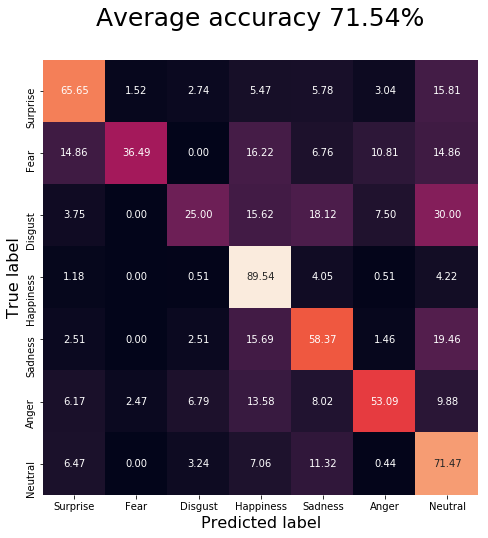

In [189]:
plot_confusion_matrix(test_label, test_predict, verbose = 0, classes = list(label_mapping.values()))

## Prediction

### True Prediction

In [261]:
filter_true = (test_label == test_predict)
idx_true = np.arange(len(test_label))[filter_true]
idx_choose = np.random.choice(len(idx_true), 56)

In [262]:
label_mapping1  = {1: "Surp", 2: "Fear", 3: "Disgust", 4: "Hap", 5: "Sad", 6: "Anger", 7: "Neu"}

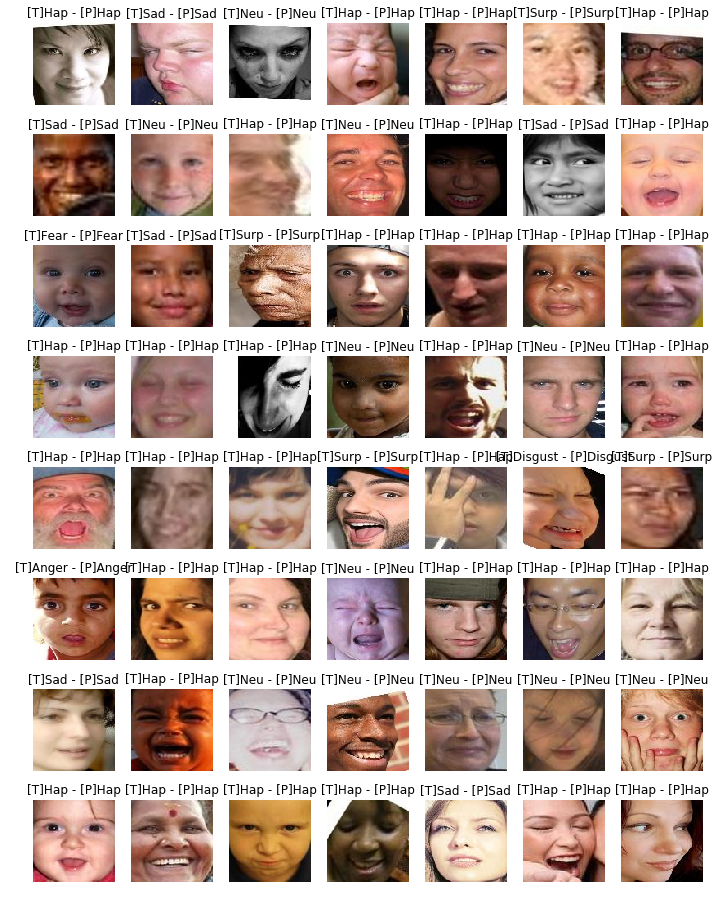

In [263]:
list_true_images = df_test["id"].values[idx_choose]
list_true_lables = [label_mapping1[v] for v in test_label[idx_true[idx_choose]]]
list_pred_lables = [label_mapping1[v] for v in test_predict[idx_true[idx_choose]]]

plt.figure(figsize=(12, 16))
for idx in range(56):
    plt.subplot(8, 7, idx + 1)
    image, info = read_aligned_image(db = df_rafdb, root_dir =  rafdb_info["root_dir"], image_id = list_true_images[idx], verbose = 0)
    plt.imshow(image[...,::-1]), plt.axis("off")
    plt.title("[T]%s - [P]%s"%(list_true_lables[idx], list_pred_lables[idx]))
# for
plt.show()

### False Prediction

In [253]:
filter_false = (test_label != test_predict)
idx_false = np.arange(len(test_label))[filter_false]
idx_choose = np.random.choice(len(idx_false), 56)

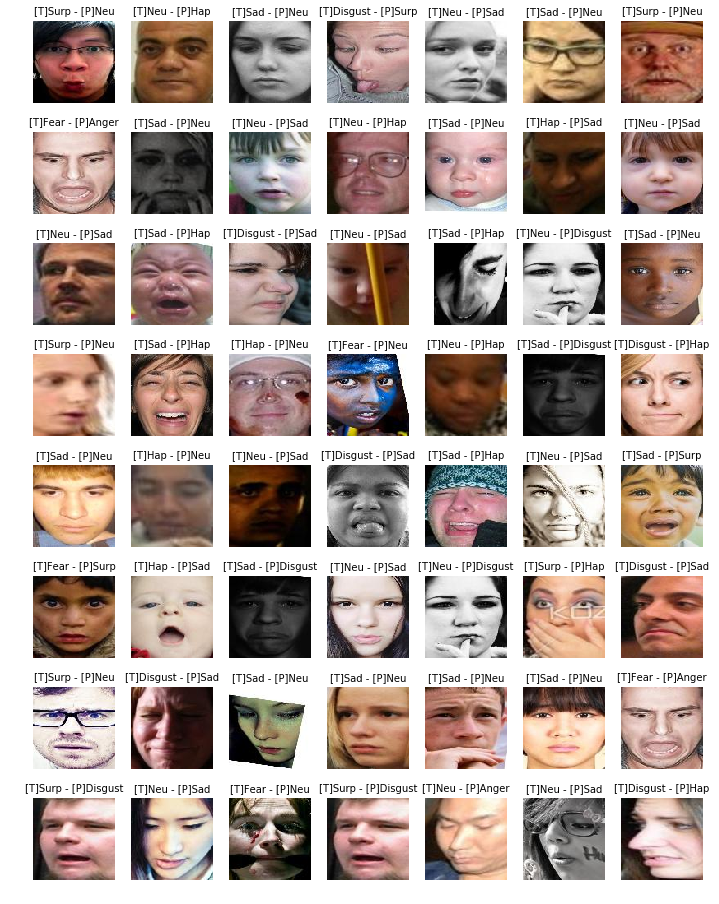

In [258]:
list_false_images = df_test["id"].values[idx_false[idx_choose]]
list_true_lables = [label_mapping1[v] for v in test_label[idx_false[idx_choose]]]
list_pred_lables = [label_mapping1[v] for v in test_predict[idx_false[idx_choose]]]

plt.figure(figsize=(12, 16))
for idx in range(56):
    plt.subplot(8, 7, idx + 1)
    image, info = read_aligned_image(db = df_rafdb, root_dir =  rafdb_info["root_dir"], image_id = list_false_images[idx], verbose = 0)
    plt.imshow(image[...,::-1]), plt.axis("off")
    plt.title("[T]%s - [P]%s"%(list_true_lables[idx], list_pred_lables[idx]), fontsize = 10)
# for
plt.show()